In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from wordcloud import WordCloud, STOPWORDS
import datetime
from textblob import TextBlob

nltk_data_path = "../data/libs/nltk_data"
nltk.data.path.append(nltk_data_path)

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [29]:
garminconnect_df = pd.read_csv("../data/processed/20250313_1413_garminconnect_df_cleaned.csv")
garminconnect_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125178 entries, 0 to 125177
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   reviewId              125178 non-null  object
 1   userName              125178 non-null  object
 2   userImage             125178 non-null  object
 3   content               125178 non-null  object
 4   score                 125178 non-null  int64 
 5   thumbsUpCount         125178 non-null  int64 
 6   reviewCreatedVersion  118529 non-null  object
 7   at                    125178 non-null  object
 8   replyContent          3815 non-null    object
 9   repliedAt             3815 non-null    object
 10  appVersion            118529 non-null  object
 11  clean_content         125178 non-null  object
dtypes: int64(2), object(10)
memory usage: 11.5+ MB


## Vader

In [8]:
# Initialize VADER
vader = SentimentIntensityAnalyzer()

# Apply VADER on clean text
garminconnect_df['sentiment'] = garminconnect_df['clean_content'].apply(lambda x: vader.polarity_scores(x)['compound'])

# Classify as Positive, Neutral, Negative
def get_sentiment_label(score):
    if score >= 0.05:
        return 'positive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

garminconnect_df['sentiment_label'] = garminconnect_df['sentiment'].apply(get_sentiment_label)

In [25]:
date_today = datetime.datetime.today().strftime("%Y%m%d_%H%M")
garminconnect_df.to_csv(f"../data/processed/{date_today}_garminconnect_df_cleaned_sentiment.csv", index=False)

## Textblob

In [30]:
# Function to extract sentiment polarity and subjectivity
def get_sentiment(text):
    blob = TextBlob(str(text))  # Ensure text is string
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis on 'clean_content'
garminconnect_df[['polarity', 'subjectivity']] = garminconnect_df['clean_content'].apply(
    lambda x: pd.Series(get_sentiment(x))
)

# Optional: Categorize sentiment into positive, neutral, negative
def categorize_sentiment(polarity):
    if polarity > 0.1:
        return 'positive'
    elif polarity < -0.1:
        return 'negative'
    else:
        return 'neutral'

garminconnect_df['sentiment_label'] = garminconnect_df['polarity'].apply(categorize_sentiment)

# Preview the results
print(garminconnect_df[['clean_content', 'polarity', 'subjectivity', 'sentiment_label']].head())

                                       clean_content  polarity  subjectivity  \
0  hate new layout try figure load previous versi... -0.038552      0.552357   
1                             love help tremendously  0.416667      0.800000   
2                                      good carefree  0.700000      0.600000   
3  late update not_allow create workout category ... -0.300000      0.600000   
4             much well fitbit no_issue sync workout  0.200000      0.200000   

  sentiment_label  
0         neutral  
1        positive  
2        positive  
3        negative  
4        positive  


In [31]:
date_today = datetime.datetime.today().strftime("%Y%m%d_%H%M")
garminconnect_df.to_csv(f"../data/processed/{date_today}_garminconnect_df_cleaned_sentiment_textblob.csv", index=False)

## Textblob Visualization

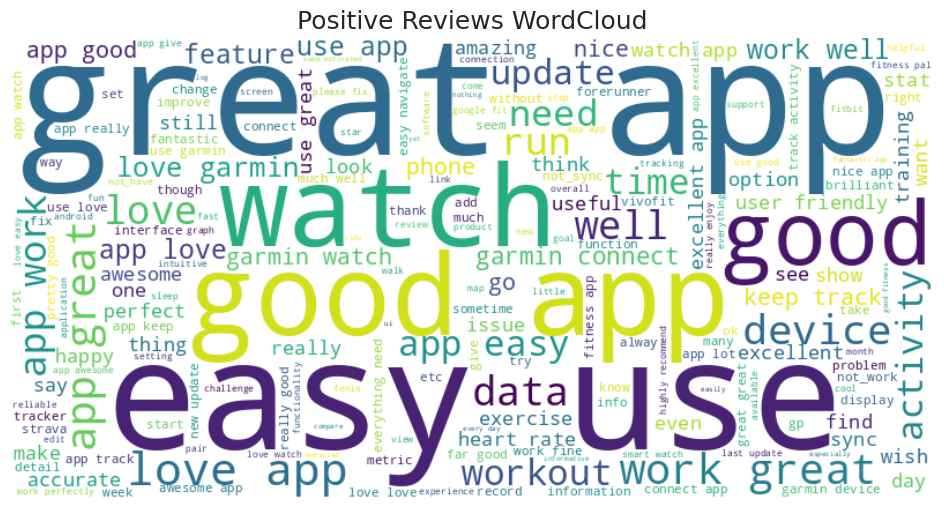

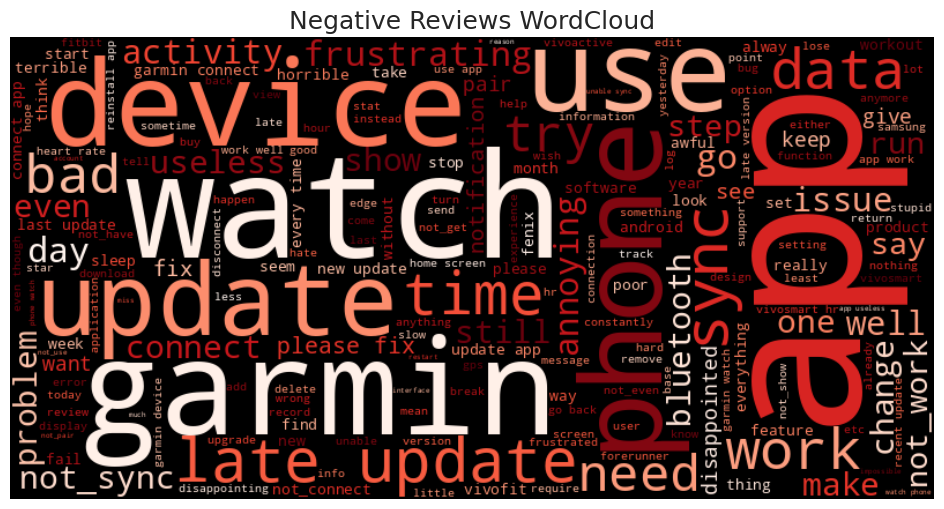

In [32]:
# Separate positive and negative texts
positive_text = " ".join(garminconnect_df[garminconnect_df['sentiment_label'] == 'positive']['clean_content'].dropna())
negative_text = " ".join(garminconnect_df[garminconnect_df['sentiment_label'] == 'negative']['clean_content'].dropna())

# Generate word clouds
positive_wc = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
negative_wc = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(negative_text)

# Plot Positive WordCloud
plt.figure(figsize=(12, 6))
plt.title("Positive Reviews WordCloud", fontsize=18)
plt.imshow(positive_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

# Plot Negative WordCloud
plt.figure(figsize=(12, 6))
plt.title("Negative Reviews WordCloud", fontsize=18)
plt.imshow(negative_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

##  Vader Visualization

/tmp/ipykernel_22123/2495168850.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment_label', data=garminconnect_df, palette='coolwarm')


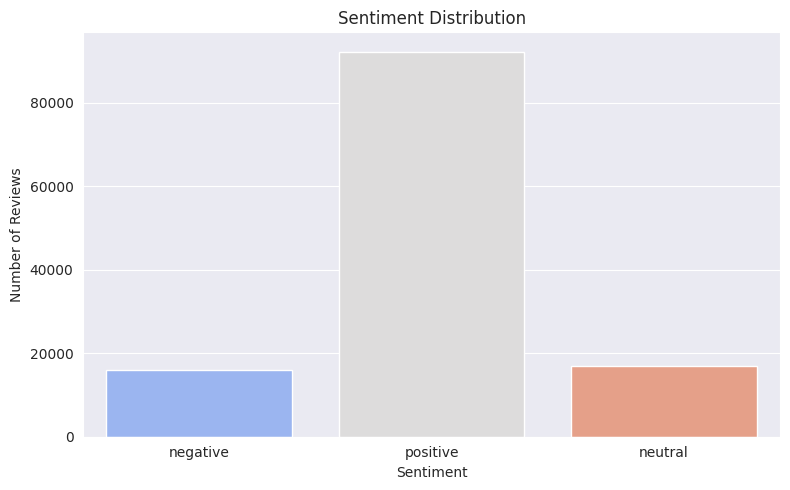

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x='sentiment_label', data=garminconnect_df, palette='coolwarm')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.tight_layout()
plt.show()

/tmp/ipykernel_22123/1946554763.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='score', y='sentiment', data=garminconnect_df, palette='Set2')


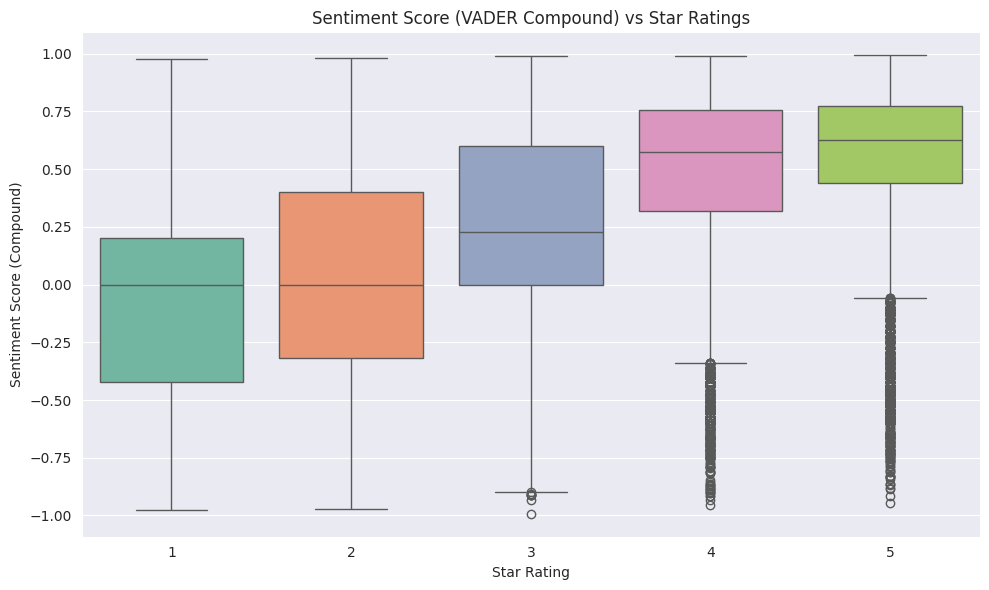

In [10]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='score', y='sentiment', data=garminconnect_df, palette='Set2')
plt.title('Sentiment Score (VADER Compound) vs Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Sentiment Score (Compound)')
plt.tight_layout()
plt.show()

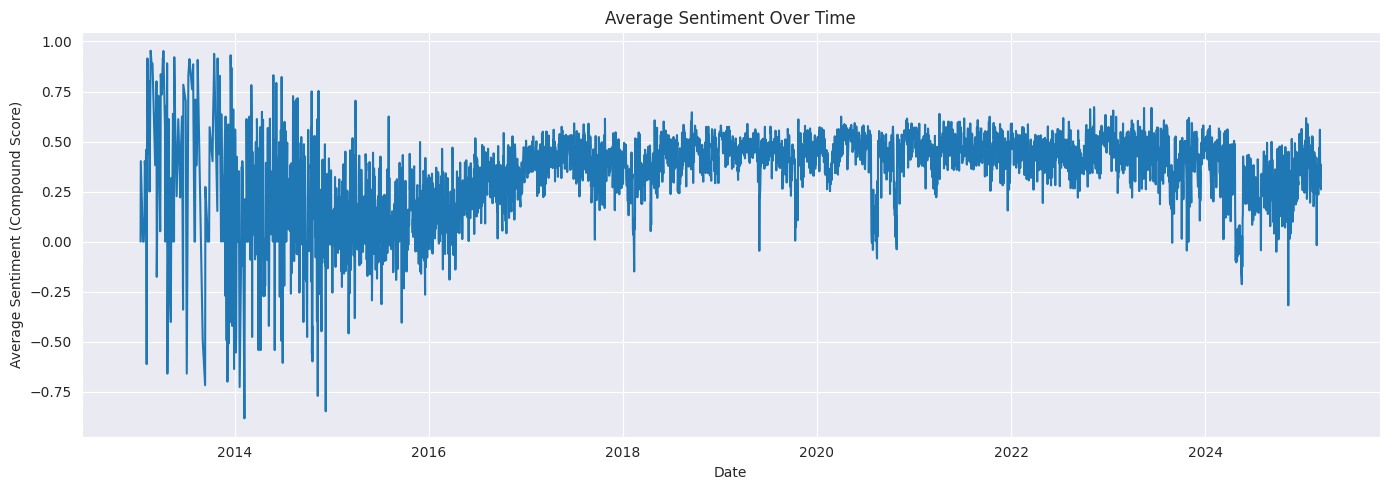

In [11]:
garminconnect_df['date'] = pd.to_datetime(garminconnect_df['at']).dt.date
avg_sentiment_by_date = garminconnect_df.groupby('date')['sentiment'].mean()

plt.figure(figsize=(14, 5))
avg_sentiment_by_date.plot()
plt.title('Average Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sentiment (Compound Score)')
plt.tight_layout()
plt.show()

In [12]:
import pandas as pd

# Define custom score sentiment (for comparison)
def score_to_sentiment(score):
    if score >= 4:
        return 'positive'
    elif score <= 2:
        return 'negative'
    else:
        return 'neutral'

garminconnect_df['score_sentiment'] = garminconnect_df['score'].apply(score_to_sentiment)

# Cross-tab
conf_matrix = pd.crosstab(garminconnect_df['score_sentiment'], garminconnect_df['sentiment_label'])

print(conf_matrix)

sentiment_label  negative  neutral  positive
score_sentiment                             
negative            12044     7189      9416
neutral              1747     1449      4121
positive             2125     8313     78774


In [20]:
# Start with default WordCloud stopwords
custom_stopwords = set(STOPWORDS)

# Extend with additional non-sentiment keywords based on your wordcloud analysis
custom_stopwords.update([
    'app', 'use', 'using', 'work', 'watch', 'device', 'update', 'connect', 'feature',
    'option', 'set', 'start', 'time', 'thing', 'etc', 'one', 'go', 'see', 'look', 'run',
    'phone', 'bluetooth', 'android', 'data', 'sync', 'activity', 'heart', 'rate',
    'screen', 'interface', 'notification', 'upload', 'download',
    'nice', 'really', 'make', 'get', 'keep', 'still', 'every', 'even', 'always', 'need',
    'garmin'
])


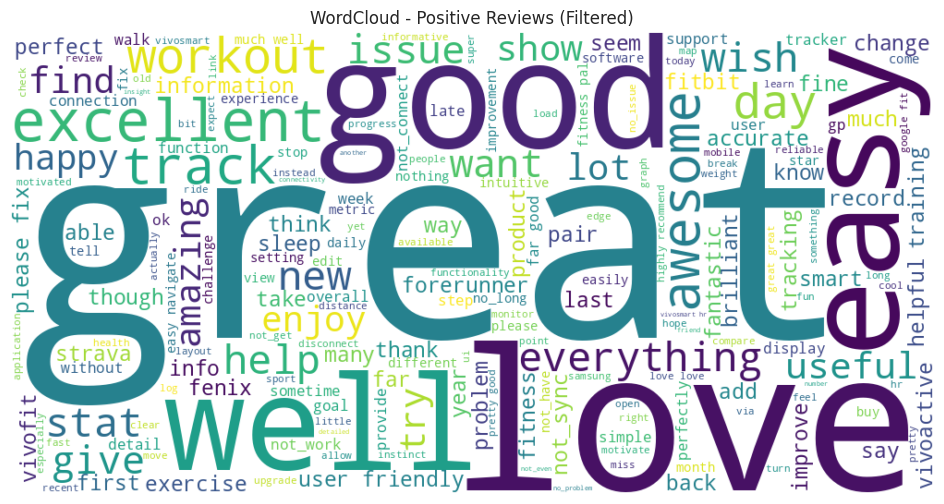

In [21]:
positive_text = " ".join(
    garminconnect_df[garminconnect_df['sentiment_label'] == 'positive']['clean_content'].dropna()
)

wordcloud_pos = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=custom_stopwords
).generate(positive_text)

plt.figure(figsize=(14, 6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Positive Reviews (Filtered)')
plt.show()


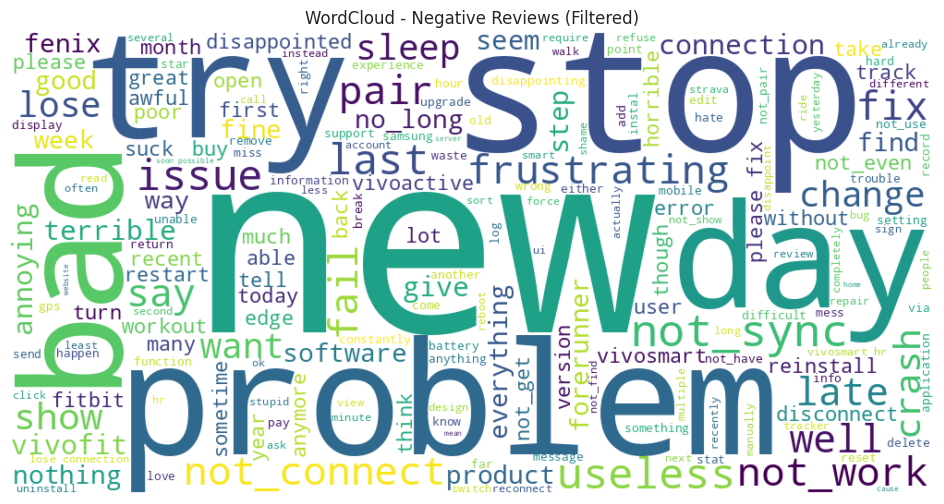

In [22]:
negative_text = " ".join(
    garminconnect_df[garminconnect_df['sentiment_label'] == 'negative']['clean_content'].dropna()
)

wordcloud_neg = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    stopwords=custom_stopwords
).generate(negative_text)

plt.figure(figsize=(14, 6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - Negative Reviews (Filtered)')
plt.show()